In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import os
os.environ['KAGGLE_USERNAME'] =''
os.environ['KAGGLE_KEY'] = ''

In [2]:
!kaggle datasets download -d emmarex/plantdisease

 99% 650M/658M [00:03<00:00, 226MB/s]
100% 658M/658M [00:03<00:00, 184MB/s]


In [ ]:
!unzip plantdisease.zip

In [4]:
#import packages
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torchvision.models as models
import glob
import shutil
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

In [5]:
#Splitting the data

# Defining the path to dataset
dataset_path = '/content/PlantVillage'

train_ratio = 0.75
valid_ratio = 0.10
test_ratio = 0.15

# The path to the output directory
output_path = '/content/PVdatasetsplit'

# Create the output directory if it doesn't exist
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Defining the names of the subdirectories for each set
train_dir = 'train'
valid_dir = 'valid'
test_dir = 'test'

# Creating the subdirectories for each set
os.makedirs(os.path.join(output_path, train_dir))
os.makedirs(os.path.join(output_path, valid_dir))
os.makedirs(os.path.join(output_path, test_dir))

# Loop over each class in the dataset
classes = os.listdir(dataset_path)
for cls in classes:
    # Create the subdirectories for each class in each set
    os.makedirs(os.path.join(output_path, train_dir, cls))
    os.makedirs(os.path.join(output_path, valid_dir, cls))
    os.makedirs(os.path.join(output_path, test_dir, cls))

    # Get the list of images for this class
    images = os.listdir(os.path.join(dataset_path, cls))
    num_images = len(images)

    # Shuffle the images
    random.shuffle(images)

    # Split the images into sets
    num_train = int(train_ratio * num_images)
    num_valid = int(valid_ratio * num_images)
    num_test = int(test_ratio * num_images)

    train_images = images[:num_train]
    valid_images = images[num_train:num_train+num_valid]
    test_images = images[num_train+num_valid:]

    # Copy the images to the corresponding subdirectories for each set
    for img in train_images:
        src_path = os.path.join(dataset_path, cls, img)
        dst_path = os.path.join(output_path, train_dir, cls, img)
        shutil.copyfile(src_path, dst_path)

    for img in valid_images:
        src_path = os.path.join(dataset_path, cls, img)
        dst_path = os.path.join(output_path, valid_dir, cls, img)
        shutil.copyfile(src_path, dst_path)

    for img in test_images:
        src_path = os.path.join(dataset_path, cls, img)
        dst_path = os.path.join(output_path, test_dir, cls, img)
        shutil.copyfile(src_path, dst_path)


In [10]:
# Defining the transformation pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the images to 224x224
    transforms.RandomHorizontalFlip(),  # Randomly flip the images horizontally
    transforms.RandomRotation(10),  # Randomly rotate the images by up to 10 degrees
    transforms.ToTensor(),  # Convert the images to PyTorch tensors
    transforms.Normalize(  # Normalize the images
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Load the dataset
train_dataset = ImageFolder('/content/PVdatasetsplit/train', transform=transform)
test_dataset = ImageFolder('/content/PVdatasetsplit/test', transform=transform)
val_dataset = ImageFolder('/content/PVdatasetsplit/valid', transform=transform)

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)


# Define the model architecture
model = models.mobilenet_v2(weights=True)
model.classifier = nn.Sequential(
    nn.Linear(1280, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, 15)
)




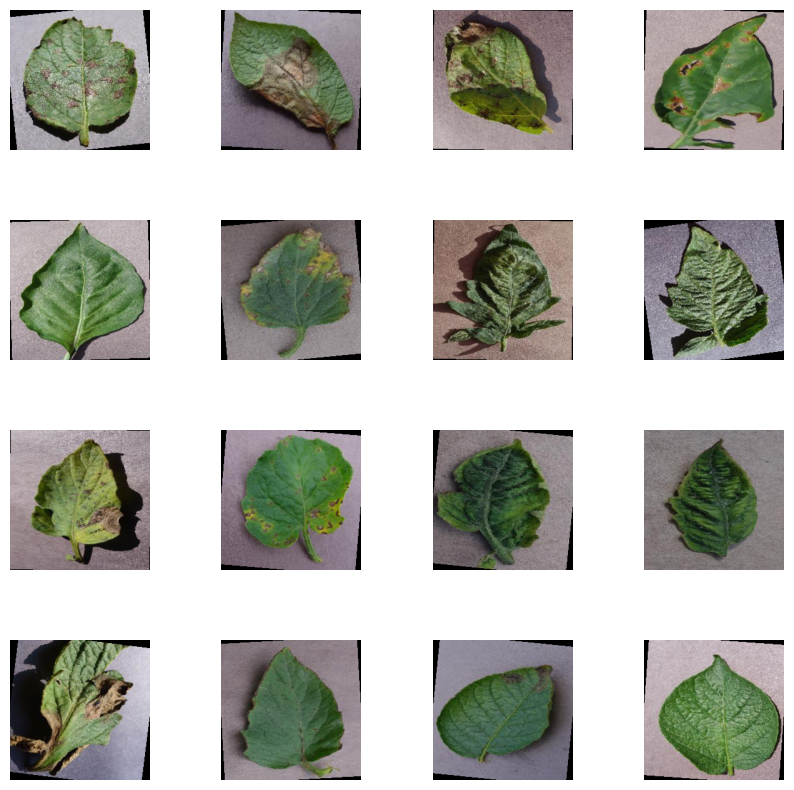

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Get a batch of images from the train loader
images, labels = next(iter(train_loader))

# Convert the PyTorch tensor to a NumPy array
images = images.numpy()

# Convert the NumPy array to a PyTorch tensor
images = torch.from_numpy(images)

# Denormalize the images
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])
images = images.permute(0, 2, 3, 1)  # Change the order of the dimensions
images = std * images + mean

# Create a figure with 4x4 subplots
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
fig.subplots_adjust(hspace=0.5, wspace=0.5) # Adjust subplot parameters
for i, ax in enumerate(axes.flat):
    # Display the image
    ax.imshow(images[i])
    ax.axis('off')
plt.show()




In [11]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on device {device}.")

# Move model to the device
model = model.to(device)

# Define the number of epochs to train for
num_epochs = 10

# Create lists to store train and validation loss and accuracy
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

# Train the model
for epoch in range(1, num_epochs+1):
    # Set the model to training mode
    model.train()
    train_loss = 0
    total_train_images = 0
    total_train_correct = 0

    # Loop over the training dataset in batches
    for images, labels in tqdm(train_loader, desc=f'Epoch {epoch}/{num_epochs}'):
        # Move data to the device
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Calculate training loss and accuracy
        train_loss += loss.item() * labels.size(0)
        _, predicted = torch.max(outputs, 1)
        total_train_correct += (predicted == labels).sum().item()
        total_train_images += labels.size(0)

    # Calculate training accuracy
    train_acc = total_train_correct / total_train_images

    # Evaluate the model on the validation set
    model.eval()
    with torch.no_grad():
        total_val_loss = 0
        total_val_correct = 0
        total_val_images = 0
        for images, labels in val_loader:
            # Move data to the device
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs, 1)
            total_val_correct += (predicted == labels).sum().item()
            total_val_images += labels.size(0)
        val_acc = total_val_correct / total_val_images
        print('Epoch [{}/{}], Training Loss: {:.4f}, Training Accuracy: {:.2f}%, Validation Loss: {:.4f}, Validation Accuracy: {:.2f}%'
              .format(epoch, num_epochs, train_loss/len(train_loader.dataset), train_acc*100, total_val_loss/len(val_loader.dataset), val_acc*100))

    # Append training and validation metrics to the corresponding lists
    train_loss_list.append(train_loss/len(train_loader.dataset))
    train_acc_list.append(train_acc*100)
    val_loss_list.append(total_val_loss/len(val_loader.dataset))
    val_acc_list.append(val_acc*100)

Training on device cuda.


Epoch 1/10: 100%|██████████| 242/242 [01:54<00:00,  2.11it/s]


Epoch [1/10], Training Loss: 0.8674, Training Accuracy: 71.94%, Validation Loss: 0.4783, Validation Accuracy: 85.28%


Epoch 2/10: 100%|██████████| 242/242 [01:54<00:00,  2.12it/s]


Epoch [2/10], Training Loss: 0.3382, Training Accuracy: 90.67%, Validation Loss: 0.1647, Validation Accuracy: 95.24%


Epoch 3/10: 100%|██████████| 242/242 [01:54<00:00,  2.12it/s]


Epoch [3/10], Training Loss: 0.2567, Training Accuracy: 92.94%, Validation Loss: 0.1874, Validation Accuracy: 94.61%


Epoch 4/10: 100%|██████████| 242/242 [01:53<00:00,  2.12it/s]


Epoch [4/10], Training Loss: 0.2028, Training Accuracy: 94.69%, Validation Loss: 0.2267, Validation Accuracy: 94.61%


Epoch 5/10: 100%|██████████| 242/242 [01:54<00:00,  2.11it/s]


Epoch [5/10], Training Loss: 0.1981, Training Accuracy: 94.78%, Validation Loss: 0.1427, Validation Accuracy: 95.87%


Epoch 6/10: 100%|██████████| 242/242 [01:54<00:00,  2.12it/s]


Epoch [6/10], Training Loss: 0.1502, Training Accuracy: 96.11%, Validation Loss: 0.1608, Validation Accuracy: 94.66%


Epoch 7/10: 100%|██████████| 242/242 [01:54<00:00,  2.12it/s]


Epoch [7/10], Training Loss: 0.1724, Training Accuracy: 95.52%, Validation Loss: 0.0860, Validation Accuracy: 97.62%


Epoch 8/10: 100%|██████████| 242/242 [01:54<00:00,  2.11it/s]


Epoch [8/10], Training Loss: 0.1370, Training Accuracy: 96.45%, Validation Loss: 0.0751, Validation Accuracy: 98.01%


Epoch 9/10: 100%|██████████| 242/242 [01:54<00:00,  2.12it/s]


Epoch [9/10], Training Loss: 0.1406, Training Accuracy: 96.47%, Validation Loss: 0.2867, Validation Accuracy: 93.97%


Epoch 10/10: 100%|██████████| 242/242 [01:54<00:00,  2.11it/s]


Epoch [10/10], Training Loss: 0.1302, Training Accuracy: 96.91%, Validation Loss: 0.0632, Validation Accuracy: 98.40%


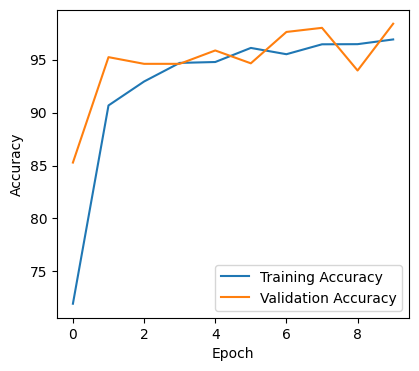

In [12]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label='Training Accuracy')
plt.plot(val_acc_list, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

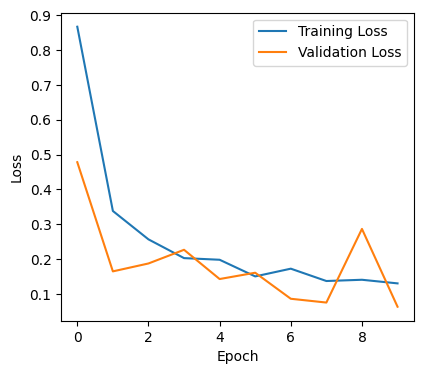

In [13]:
# Plot the training and validation loss and accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [14]:
# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    total_test_loss = 0
    total_correct = 0
    total_images = 0
    # Use tqdm to add a progress bar
    for images, labels in tqdm(test_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        total_test_loss += loss.item() * labels.size(0)
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
        total_images += labels.size(0)
    test_loss = total_test_loss / total_images
    accuracy = total_correct / total_images
    print('Test Loss: {:.4f}, Test Accuracy: {:.2f}%'.format(test_loss, accuracy*100))

100%|██████████| 49/49 [00:16<00:00,  2.93it/s]

Test Loss: 0.0629, Test Accuracy: 98.16%


In [15]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Set the model to evaluation mode
model.eval()

# Initialize lists to store true labels and predicted labels
true_labels = []
pred_labels = []

# Loop over the validation dataset in batches
for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    # Predict the labels
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    # Append the true and predicted labels to the corresponding lists
    true_labels.extend(labels.tolist())
    pred_labels.extend(predicted.tolist())

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Compute precision, recall, and F-score
precision = precision_score(true_labels, pred_labels, average='macro')
recall = recall_score(true_labels, pred_labels, average='macro')
f_score = f1_score(true_labels, pred_labels, average='macro')

print('Precision: {:.4f}, Recall: {:.4f}, F-score: {:.4f}'.format(precision, recall, f_score))

Precision: 0.9746, Recall: 0.9837, F-score: 0.9785


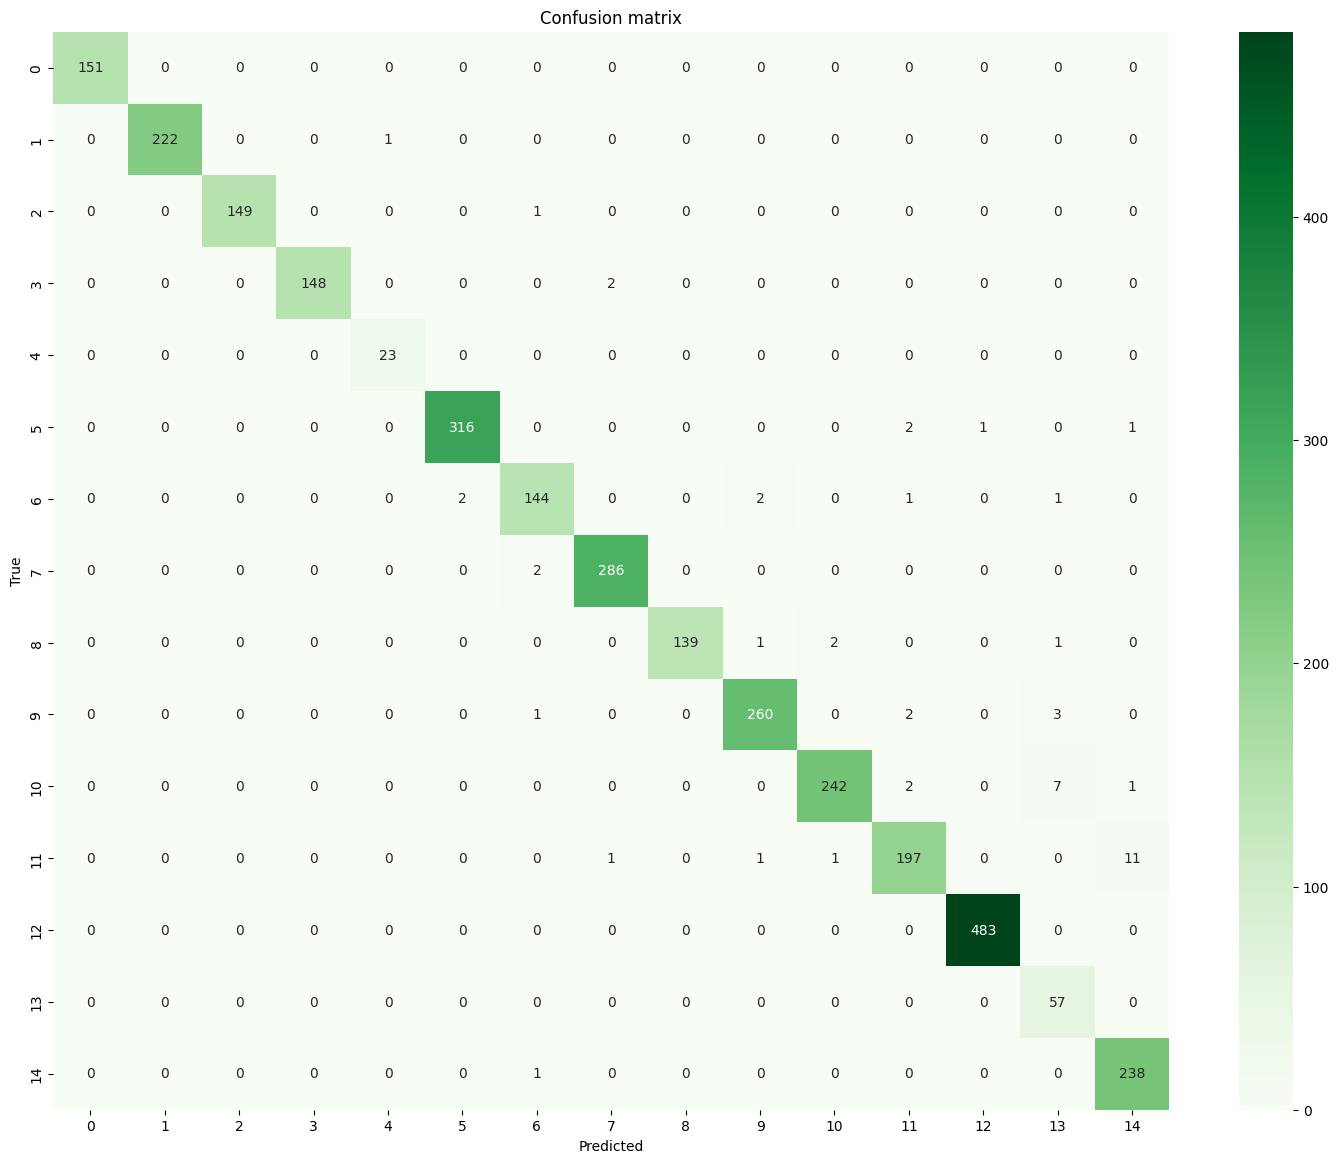

In [16]:
# Plot the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(18, 14))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [17]:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}, '/content/drive/MyDrive/SavedModels/Dataset2_transferlearning')